In [1]:
import plac
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import SGD
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import zipfile
import matplotlib.pyplot as plt


In [2]:
class IndexedDataset(Dataset):
    """ 
    Wraps another dataset to sample from. Returns the sampled indices during iteration.
    In other words, instead of producing (X, y) it produces (X, y, idx)
    """
    def __init__(self, base_dataset):
        self.base = base_dataset

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        return (img, label, idx)

class Generator_dist(nn.Module):
    def __init__(self,code_dim, d=128):
        super(Generator_dist, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(code_dim, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class Generator_signal(nn.Module):
        def __init__(self,code_dim, d=128):
            super(Generator_signal, self).__init__()
            self.deconv1 = nn.ConvTranspose2d(code_dim, d*8, 4, 1, 0)
            self.deconv1_bn = nn.BatchNorm2d(d*8)
            self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
            self.deconv2_bn = nn.BatchNorm2d(d*4)
            self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
            self.deconv3_bn = nn.BatchNorm2d(d*2)
            self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
            self.deconv4_bn = nn.BatchNorm2d(d)
            self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

        # forward method
        def forward(self, input):
            x = F.relu(self.deconv1_bn(self.deconv1(input)))
            x = F.relu(self.deconv2_bn(self.deconv2(x)))
            x = F.relu(self.deconv3_bn(self.deconv3(x)))
            x = F.relu(self.deconv4_bn(self.deconv4(x)))
            x = F.tanh(self.deconv5(x))
            return x

In [7]:
code_dim_dist =50
code_dim_signal = 100
epochs =500
lr_h=1.
lr_m = 1.
height = 64

image_num = 5 # Pick a number between 0-9

use_cuda = False
device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")

def maybe_cuda(tensor):
    return tensor.cuda() if use_cuda else tensor

#########    distortion code    #########
TRANSFORM_IMG = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
    transforms.Resize(height),
    transforms.ToTensor()
        ])

#########   Load distortion data
#########   One of the ditortion will be randomly selected
train_set_dist = IndexedDataset(torchvision.datasets.ImageFolder(root='Distortion_Used/',
          transform=TRANSFORM_IMG)
                           )
train_loader_dist = torch.utils.data.DataLoader(dataset=train_set_dist,
    batch_size=1, shuffle=True,
    drop_last=True, num_workers =8, pin_memory = use_cuda)

#########      Initialize the weights of distortion generator
g_dist = Generator_dist(code_dim_dist)
g_dist.load_state_dict(torch.load('weights/Distortion_spread_Gen_cd50_h64.pwf', map_location=lambda storage, loc: storage))

#########     signal code       #########

#########     Load MNIST dataset 
train_set_signal = IndexedDataset(
    MNIST(root='./data/MNIST', download = True, train = True,
         transform=transforms.Compose([
             transforms.Resize(64),
             transforms.ToTensor()
         ]))
    )

train_loader_signal = torch.utils.data.DataLoader(dataset=train_set_signal,
    batch_size=1, shuffle=True,
    drop_last=True, num_workers =8, pin_memory = use_cuda)

#########      Initialize the weights of MNIST (signal) generator
g_signal = Generator_signal(code_dim_signal)
g_signal.load_state_dict(torch.load('weights/MNIST_DCGAN_Gen_cd100_h64.pwf', map_location=lambda storage, loc: storage))


<All keys matched successfully>

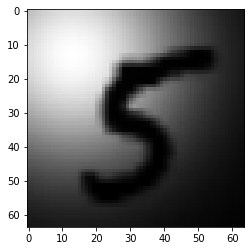

In [10]:
#########      creating modulated data         #########
dist_example = enumerate(train_loader_dist)
i, (dist_example_data,_,idx) = next(dist_example)

#########      Select a distortion image
x0 = dist_example_data[0][0]

signal_example = enumerate(train_loader_signal)
i, (signal_example_data,target_example_data,idx) = next(signal_example)

##########      Select an MNIST image with the number in the image as "image_num" (seleted above)
while target_example_data[0].numpy() != image_num:
  i, (signal_example_data,target_example_data,idx) = next(signal_example)

w0 = 1-signal_example_data[0][0]

#########   observatiomn
y0 = torch.mul(w0, x0)

plt.imshow(y0,cmap='gray')

In [11]:
h = maybe_cuda(torch.randn(1,code_dim_signal))
h = Variable(h,requires_grad=True)

m = maybe_cuda(torch.randn(1,code_dim_dist))
m = Variable(m, requires_grad=True)


optimizer = SGD([
    {'params': h, 'lr':lr_h},
    {'params': m, 'lr':lr_m}
],momentum=0.9)


grad_size = 1
epoch = 0
#########      FIRST LOOP       ####################

#########      Check if the reflection (about h and m axis) of current guess 
#########      has lower objective value
h_temp_0 = h.data
m_temp_0 = m.data
h_temp_1 = h.data
m_temp_1 = m.data
change = 0
y_temp_0 = torch.mul(g_dist(m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(h_temp_0.view(1,code_dim_signal,1,1)))
y_temp_1 = torch.mul(g_dist(-1*m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(h_temp_0.view(1,code_dim_signal,1,1)))

if (y_temp_1-y0).pow(2).mean()<(y_temp_0-y0).pow(2).mean():
    y_temp_0=y_temp_1
    m_temp_1 = -1*m_temp_0
    h_temp_1 = h_temp_0
    change =1

y_temp_1 = torch.mul(g_dist(m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(-1*h_temp_0.view(1,code_dim_signal,1,1)))
if (y_temp_1-y0).pow(2).mean()<(y_temp_0-y0).pow(2).mean():
    y_temp_0=y_temp_1
    h_temp_1 = -1*h_temp_0 
    m_temp_1 = m_temp_0
    change=2

y_temp_1 = torch.mul(g_dist(-1*m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(-1*h_temp_0.view(1,code_dim_signal,1,1)))
if (y_temp_1-y0).pow(2).mean()<(y_temp_0-y0).pow(2).mean():
    y_temp_0=y_temp_1
    h_temp_1 = -1*h_temp_0 
    m_temp_1 = -1*m_temp_0
    change=3

h.data = h_temp_1
m.data = m_temp_1

y_pred = torch.mul(g_dist(m.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(h.view(1,code_dim_signal,1,1)))
loss=(y_pred-y0).pow(2).mean()
optimizer.zero_grad()
loss.backward()  
optimizer.step()

grad_size = h.grad.norm()+m.grad.norm()
    
epoch = epoch +1;
print("epoch = %s, loss = %s, changed = %s, norm of gradient = %s" %(epoch,loss.cpu().data.numpy(),change,grad_size.cpu().data.numpy()))   
######## END FIRST LOOP ###################


while epoch<500:
    
    if epoch%100 == 0: 
        #########      Check if the reflection (about h and m axis) of current guess 
        #########      has lower objective value
        h_temp_0 = h.data
        m_temp_0 = m.data
        h_temp_1 = h.data
        m_temp_1 = m.data
        change = 0
        y_temp_0 = torch.mul(g_dist(m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(h_temp_0.view(1,code_dim_signal,1,1)))
        y_temp_1 = torch.mul(g_dist(-1*m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(h_temp_0.view(1,code_dim_signal,1,1)))

        if (y_temp_1-y0).pow(2).mean()<(y_temp_0-y0).pow(2).mean():
          y_temp_0 =y_temp_1
          m_temp_1 = -1*m_temp_0
          h_temp_1 = h_temp_0
          change =1

        y_temp_1 = torch.mul(g_dist(m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(-1*h_temp_0.view(1,code_dim_signal,1,1)))
        if (y_temp_1-y0).pow(2).mean()<(y_temp_0-y0).pow(2).mean():
          y_temp_0=y_temp_1
          h_temp_1 = -1*h_temp_0 
          m_temp_1 = m_temp_0
          change=2

        y_temp_1 = torch.mul(g_dist(-1*m_temp_0.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(-1*h_temp_0.view(1,code_dim_signal,1,1)))
        if (y_temp_1-y0).pow(2).mean()<(y_temp_0-y0).pow(2).mean():
          y_temp_0=y_temp_1
          h_temp_1 = -1*h_temp_0 
          m_temp_1 = -1*m_temp_0
          change=3

    scale = h.data.norm()/m.data.norm()
    scale = scale.sqrt()
    
    h.data = h.data/scale
    m.data = m.data*scale
        
    y_pred = torch.mul(g_dist(m.view(1,code_dim_dist,1,1)).view(1,1,height,height),g_signal(h.view(1,code_dim_signal,1,1)))
    loss=(y_pred-y0).pow(2).mean()
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()

    grad_size = h.grad.norm()+m.grad.norm()
    
    epoch = epoch +1;
    if epoch % 50 == 0:
        print("epoch = %s, loss = %s, changed = %s, norm of gradient = %s" %(epoch,loss.cpu().data.numpy(),change,grad_size.cpu().data.numpy()))   
    
print("Done!")

epoch = 1, loss = 0.09164057, changed = 1, norm of gradient = 0.17520623
epoch = 50, loss = 0.0061988486, changed = 1, norm of gradient = 0.0024198915
epoch = 100, loss = 0.005311169, changed = 1, norm of gradient = 0.0010367406
epoch = 150, loss = 0.0047938414, changed = 0, norm of gradient = 0.0013847841
epoch = 200, loss = 0.0044661057, changed = 0, norm of gradient = 0.0004603647
epoch = 250, loss = 0.004413876, changed = 0, norm of gradient = 0.0003013504
epoch = 300, loss = 0.0043859147, changed = 0, norm of gradient = 0.0002698961
epoch = 350, loss = 0.0043647923, changed = 0, norm of gradient = 0.00024303388
epoch = 400, loss = 0.00434904, changed = 0, norm of gradient = 0.00021741257
epoch = 450, loss = 0.004335517, changed = 0, norm of gradient = 0.00020580518
epoch = 500, loss = 0.0043245396, changed = 0, norm of gradient = 0.00018851022
Done!


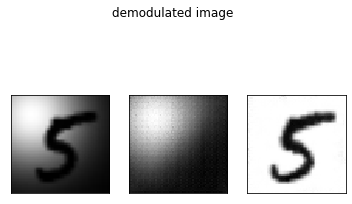

In [12]:
#########    Plot Results      #########

fig, axs = plt.subplots(1,3)
fig.suptitle('demodulated image')
axs[0].imshow(y0,cmap='gray')
axs[0].axes.get_xaxis().set_visible(False) 
axs[0].axes.get_yaxis().set_visible(False) 

axs[1].imshow(g_dist(m.view(1,code_dim_dist,1,1)).view(1,1,height,height)[0][0].detach().numpy(),cmap='gray')
axs[1].axes.get_xaxis().set_visible(False) 
axs[1].axes.get_yaxis().set_visible(False) 

axs[2].imshow(g_signal(h.view(1,code_dim_signal,1,1))[0][0].detach().numpy(),cmap='gray')
axs[2].axes.get_xaxis().set_visible(False) 
axs[2].axes.get_yaxis().set_visible(False) 
